# 論文「区間チェビシェフ補間による精度保証付き数値計算」に掲載されたコード一覧


In [1]:
# Section 2.1
function chebcoeffs(f, M, I=[-1, 1])
    a = I[1]
    b = I[2]
    n = M - 1
    cpts = chebpts(n, a, b) # Chebyshev points on [a,b]
    fvals = f.(cpts)
    FourierCoeffs = real(fft([reverse(fvals); fvals[2:end-1]])) # require FFTW.jl
    ChebCoeffs = FourierCoeffs[1:n+1] / n
    ChebCoeffs[1] = ChebCoeffs[1] / 2
    ChebCoeffs[end] = ChebCoeffs[end] / 2
    return ChebCoeffs # return Two-sided Chebyshev coefficients
end

chebcoeffs (generic function with 2 methods)

In [2]:
# Section 2.2
function cheb(f, I=[-1, 1]; tol=5e-15, Nmax=10000)
    a = I[1]
    b = I[2]
    i = 2
    schbc = 0
    while true
        schbc = chebcoeffs(f, 2^i + 1, I) # compute Chebyshev coefficients via FFT
        if all(abs.(schbc[end-2:end]) .< tol) || (2^i + 1 > Nmax)
            break
        end
        i += 1
    end
    M = findlast(abs.(schbc) .> tol)
    return schbc[1:M] # return Two-sided Chebyshev
end

cheb (generic function with 2 methods)

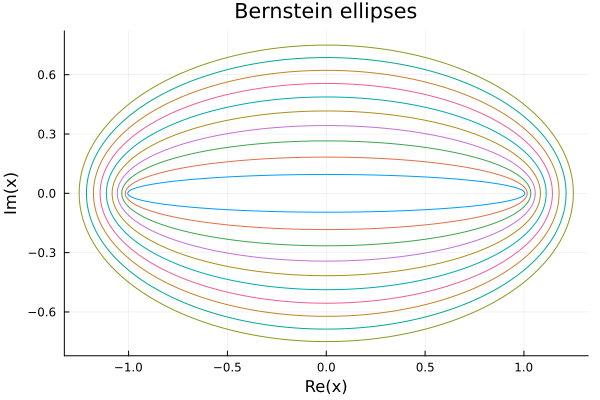

In [3]:
# Section 2.3, Figure 1
using Plots
# using LaTeXStrings
x = Vector(-1:0.01:1)
z = exp.(im * π * x)
plt = plot()
for rho = 1.1:0.1:2
    e = (rho * z + (rho * z) .^ (-1)) / 2
    plot!(plt, e)
end
plot!(plt, legend=false, title="Bernstein ellipses", aspect_ratio=:equal)
# size = (800,400))
# savefig("fig_ber.pdf")

In [4]:
# Section 3
function interval_cheb(f, I=[-1, 1]; eps=2^-52, div=2^-3)
    a = cheb(f, I)
    M = length(a) # Set M
    tM = nextpow(2, M) + 1
    ip = interval_chebcoeffs(f, tM, I) # Coeffs of \tilde{p}(x)
    ip = truncCheb(ip, M) # Coeffs of truncated interval Chebyshev interpolant
    rho = eps^(-1.0 / (tM - 1)) # Step 1: Set rho of Bernstein ellipse
    fz = fzeval(f, rho, div)# Step 2: Evaluate f(z) via interval arithmetic
    # Step 3: Interpolation error estimate
    err = (4 * rho^(-(tM - 1)) / (rho - 1)) * fz
    # midrad form of interval Cheb interpolation
    ip[1] = ip[1] + interval(0, err; format=:midpoint)
    return ip
end

interval_cheb (generic function with 2 methods)

In [5]:
# Section 3.1
include("IntervalCheb.jl")
f(x) = exp(1 - x^2)
f(x::Interval{T}) where {T} = exp(interval(1) - x^2)
function f(x::Complex{Interval{T}}) where {T}
    z = interval(1) - x * x
    zr = real(z)
    zi = imag(z)
    return exp(zr) * complex(cos(zi), sin(zi))
end

f (generic function with 3 methods)

In [6]:
ip = interval_cheb(f)
# maximum(radius,ip)

23-element Vector{Interval{Float64}}:
 [1.75338, 1.75339]_com
 [0.0, 0.0]_com
 [-0.850392, -0.850391]_com
 [0.0, 0.0]_com
 [0.105208, 0.105209]_com
 [0.0, 0.0]_com
 [-0.00872211, -0.0087221]_com
 [0.0, 0.0]_com
 [0.000543436, 0.000543437]_com
 [0.0, 0.0]_com
   ⋮
 [-4.02456e-08, -4.02455e-08]_com
 [0.0, 0.0]_com
 [1.25658e-09, 1.25659e-09]_com
 [0.0, 0.0]_com
 [-3.48816e-11, -3.48801e-11]_com
 [0.0, 0.0]_com
 [8.70989e-13, 8.7201e-13]_com
 [0.0, 0.0]_com
 [-2.04413e-14, -1.91872e-14]_com

In [7]:
f(x) = 1 / (1+12x^2)
f(x::Interval{T}) where {T<:Real} = interval(1)/(interval(1) + interval(12)*x^2) # Define f when the input is a interval type
f(x::Complex{Interval{T}}) where {T<:Real} = interval(1)/(interval(1) + interval(12)*x*x) # Define f when the input is a complex interval type
dom = [0,1]
ip = interval_cheb(f,dom;divx=2^-4)
# ip = interval_cheb(f,dom;divx=2^-7,divr=2^-3)
# radius.(ip)

42-element Vector{Interval{Float64}}:
 [0.420875, 0.420877]_com
 [-0.476215, -0.476213]_com
 [0.151765, 0.151766]_com
 [-0.00561964, -0.00561963]_com
 [-0.0273638, -0.0273637]_com
 [0.0198181, 0.0198183]_com
 [-0.00789185, -0.00789184]_com
 [0.00130871, 0.00130872]_com
 [0.000729639, 0.00072964]_com
 [-0.000766657, -0.000766656]_com
   ⋮
 [2.17317e-12, 2.17394e-12]_com
 [5.54706e-13, 5.5524e-13]_com
 [-8.25608e-13, -8.24989e-13]_com
 [4.4859e-13, 4.49033e-13]_com
 [-1.36799e-13, -1.36119e-13]_com
 [5.54272e-16, 1.09511e-15]_com
 [2.70984e-14, 2.78843e-14]_com
 [-1.91419e-14, -1.87018e-14]_com
 [6.84754e-15, 7.65053e-15]_com

In [8]:
# Section 4.1
function chebdiff(p, I=[-1, 1])# Input is Two-sided
    M = length(p)
    b = zeros(M + 1)
    for r = M-1:-1:1
        b[r] = b[r+2] + 2 * r * p[r+1]
    end
    b[1] /= 2.0
    return b[setdiff(1:end, end)] * (2 / (I[2] - I[1])) # Output is Two-sided
end

chebdiff (generic function with 4 methods)

In [9]:
# Section 4.2
function chebindefint(p, I=[-1, 1]) # Input is Two-sided
  M = length(p)
  p_ext = zeros(M + 2)
  p_ext[1] = 2 * p[1]
  p_ext[2:M] = p[2:M]
  P = zeros(M + 1)
  for n = 1:M
    P[n+1] = (p_ext[n] - p_ext[n+2]) / (2n)
  end
  # P[1] = 0 means the zero average of the integral
  return P * (I[2] - I[1]) / 2
end

chebindefint (generic function with 4 methods)

In [10]:
function chebint(p, I=[-1, 1]) # Input is Two-sided
    M = length(p)
    n = 0:2:M-1
    return sum(2p[1:2:end] ./ (1.0 .- n .^ 2)) * ((I[2] - I[1]) / 2)
end

chebint (generic function with 6 methods)

In [11]:
# Section 4.3
include("IntervalFunctions.jl")
function chebroots(ip, I=[-1, 1]) # Input is two-sided Chebyshev
    I_lo = I[1]
    I_up = I[2]
    p = mid.(ip)
    n = length(ip)
    du = [ones(n - 3) * 0.5; 1] # no error because there elements are power of 2
    dl = ones(n - 2) * 0.5 # no error because there elements are power of 2
    d = zeros(n - 1)

    C_1 = Tridiagonal(dl, d, du)
    iC_1 = interval(C_1)
    iC_2 = interval(zeros(n - 1, n - 1))
    iC_2[:, 1] = reverse(ip[1:end-1] / ip[n])
    iC_2 = interval(0.5) * iC_2
    iC = iC_1 - iC_2

    lam, X = eigen(mid.(iC))
    allroots = verifyalleig(iC,X)
    ε = maximum(radius,real(allroots))
    # ε = 100 * eps() * (I_up - I_lo) * 0.5
    if ε < 1e-3 # maximum tolerance for output
        isinI = -1.0 - ε .<= inf.(real(allroots)) .&& sup.(real(allroots)) .<= 1.0 + ε
        isreR = issubset_interval.(interval(0.0),imag(allroots))
        ind = findall(isinI .&& isreR)
        if I_lo==-1.0 && I_up==1.0
            return real(allroots[ind])
        else
            ix = real(allroots[ind])
            return (1.0 .- ix).*I_lo/2 + (1.0 .+ ix).*I_up/2
        end
    else
        return NaN
    end
end
# function chebroots(ip, I=[-1, 1]) # Input is two-sided Chebyshev
#     I_lo = I[1]
#     I_up = I[2]
#     p = mid.(ip)
#     n = length(ip)
#     du = [ones(n - 3) * 0.5; 1] # no error because there elements are power of 2
#     dl = ones(n - 2) * 0.5 # no error because there elements are power of 2
#     d = zeros(n - 1)

#     C_1 = Tridiagonal(dl, d, du)
#     iC_1 = interval(C_1)
#     iC_2 = interval(zeros(n - 1, n - 1))
#     iC_2[:, 1] = reverse(ip[1:end-1] / ip[n])
#     iC_2 = interval(0.5) * iC_2
#     iC = iC_1 - iC_2
#     C = mid.(iC)

#     lam, x = eigen(C)
#     ε = 100 * eps() * (I_up - I_lo) * 0.5
#     ind = findall((-1 - ε .<= real(lam) .<= 1 + ε) .& isapprox.(imag(lam), 0))
#     lam = real(lam[ind]) # Approximate zeros
#     x = real(x[:, ind]) # Approximate eigenvector
#     ilam = interval(zeros(length(lam)))

#     for i = 1:length(lam)
#         ilam[i] = verifyeig(iC, lam[i], x[:, i])
#     end

#     if I_lo == -1.0 && I_up == 1.0
#         return ilam
#     else
#         return (1.0 .- ilam) .* I_lo / 2 + (1.0 .+ ilam) .* I_up / 2
#     end
# end

chebroots (generic function with 4 methods)

In [12]:
# Section 4.4
function chebmax(ia, I=[-1,1]) # Input is two-sided Chebyshev
    I_lo = interval(I[1]); I_up = interval(I[2]); M = length(ia)
    i1 = interval(1.0); i2 = interval(2.0)
    ep = endpoints_of_cheb(ia)
    midrad!(ia)
    ix = chebroots(chebdiff(ia, I))
    k = 0:M-1
    fxc = cos.(interval(Vector(k))' .* acos.(ix)) * ia
    fvals = [ep[1];fxc[1:end];ep[2]]
    ix = [-i1; ix; i1]
    ind = findall(isequal_interval.(fvals,maximum(fvals)))
    if isempty(ind)
        return maximum(fvals)
    else
        return fvals[ind], (i1 .- ix[ind]).* I_lo/i2 + (i1 .+ ix[ind]).*I_up/i2
    end
end

chebmax (generic function with 2 methods)

In [13]:
function chebmin(ia, I=[-1, 1]) # Input is two-sided Chebyshev
    I_lo = interval(I[1]); I_up = interval(I[2]); M = length(ia)
    i1 = interval(1.0); i2 = interval(2.0)
    ep = endpoints_of_cheb(ia)
    midrad!(ia)
    ix = chebroots(chebdiff(ia, I))
    k = 0:M-1
    fxc = cos.(interval(Vector(k))' .* acos.(ix)) * ia
    fvals = [ep[1]; fxc[1:end]; ep[2]]
    ix = [-i1; ix; i1]
    ind = findall(isequal_interval.(fvals, minimum(fvals)))
    if isempty(ind)
        return minimum(fvals)
    else
        return fvals[ind], (i1 .- ix[ind]).* I_lo/i2 + (i1 .+ ix[ind]).*I_up/i2
    end
end

chebmin (generic function with 2 methods)

In [14]:
# Section 5.1
f(x) = 4 / (1 + x^2)
f(x::Interval{T}) where {T<:Real} = interval(4) / (interval(1) + x^2)
f(x::Complex{Interval{T}}) where {T<:Real} = interval(4) / (interval(1) + x * x)
dom = [0, 1]
ip = interval_cheb(f, dom)

23-element Vector{Interval{Float64}}:
 [3.10754, 3.10755]_com
 [-1.06635, -1.06634]_com
 [-0.100688, -0.100687]_com
 [0.0682289, 0.068229]_com
 [-0.00752218, -0.00752217]_com
 [-0.00185697, -0.00185696]_com
 [0.000687293, 0.000687294]_com
 [-3.61477e-05, -3.61476e-05]_com
 [-2.58243e-05, -2.58242e-05]_com
 [6.33881e-06, 6.33882e-06]_com
   ⋮
 [-3.40586e-09, -3.40585e-09]_com
 [3.65637e-10, 3.6564e-10]_com
 [9.44655e-11, 9.44674e-11]_com
 [-3.41643e-11, -3.41616e-11]_com
 [1.69401e-12, 1.69603e-12]_com
 [1.30067e-12, 1.30312e-12]_com
 [-3.14619e-13, -3.12619e-13]_com
 [-6.17217e-15, -3.63348e-15]_com
 [1.45715e-14, 1.67588e-14]_com

In [15]:
iPi = chebint(ip, dom)

[3.14159, 3.1416]_com

In [16]:
radius(iPi)

5.1958437552457326e-14

In [17]:
# Section 5.2
f(x) = exp(-x^2) #erf関数の被積分関数: 2 / sqrt(π)は後でかける
f(x::Interval{T}) where {T<:Real} = exp(-x^interval(2)) #*(interval(2) / sqrt(interval(π)))
f(x::Complex{Interval{T}}) where {T<:Real} = exp(-x * x)

dom = [0.0, 6.0] # L = 6
ip = interval_cheb(f, dom)
iA = chebindefint(ip, dom)
erf1(x) = eval_interval_cheb(iA, x, dom) * (interval(2) / sqrt(interval(π)))

erf1 (generic function with 1 method)

In [18]:
function erf2(x)
    dom = [0, x]
    ia = interval_cheb(f, dom)
    return chebint(ia, dom) * (interval(2) / sqrt(interval(π)))
end

erf2 (generic function with 1 method)

In [19]:
n = 150
xx = abs.(6(2rand(n) .- 1))
@time @show maximum(radius, erf1.(xx))
@time @show maximum(radius, erf1.(xx))
@time @show maximum(radius, erf2.(xx))
@time @show maximum(radius, erf2.(xx));

maximum(radius, erf1.(xx)) = 6.23945339839338e-13
  0.257826 seconds (1.60 M allocations: 107.835 MiB, 5.79% gc time, 99.09% compilation time)
maximum(radius, erf1.(xx)) = 6.23945339839338e-13
  0.002118 seconds (1.86 k allocations: 443.102 KiB, 0.01% compilation time)
maximum(radius, erf2.(xx)) = 9.17033116110133e-12
  0.112143 seconds (1.19 M allocations: 78.908 MiB, 4.38% gc time, 60.98% compilation time)
maximum(radius, erf2.(xx)) = 9.17033116110133e-12
  0.041587 seconds (791.75 k allocations: 52.475 MiB, 8.78% gc time)


In [20]:
# Section 5.3
include("IntervalCheb.jl")
f(x) = exp(erf(-x^2) + x^5) * sinpi(5x) + x
function f(x::Interval{T}) where {T<:Real}
  return exp(erf(-x^interval(2)) + x^interval(5)) * sinpi(interval(5) * x) + x
end
function f(x::Complex{Interval{T}}) where {T<:Real}
  return exp(erf(-x * x) + x * x * x * x * x) * sin(interval(5) * interval(π) * x) + x
end

ip = interval_cheb(f; divx=2^-9, divr=2^-6)

50-element Vector{Interval{Float64}}:
 [0.0578631, 0.0578632]_com
 [1.16249, 1.1625]_com
 [0.0936986, 0.0936987]_com
 [0.112823, 0.112824]_com
 [0.0283824, 0.0283825]_com
 [0.00230576, 0.00230577]_com
 [-0.0598924, -0.0598923]_com
 [-0.157572, -0.157571]_com
 [-0.103387, -0.103386]_com
 [-0.25178, -0.251779]_com
   ⋮
 [-2.45976e-10, -2.45873e-10]_com
 [-8.73439e-11, -8.72532e-11]_com
 [1.09234e-11, 1.1034e-11]_com
 [1.12953e-11, 1.13736e-11]_com
 [1.68586e-12, 1.79318e-12]_com
 [-1.19064e-12, -1.10847e-12]_com
 [-5.17975e-13, -4.24438e-13]_com
 [6.4091e-14, 1.13787e-13]_com
 [9.10382e-15, 1.02752e-13]_com

In [21]:
fmax, xmax = chebmax(ip)

(Interval{Float64}[Interval{Float64}(1.775525325758166, 1.7755253260107162, com)], Interval{Float64}[Interval{Float64}(0.9144673212826753, 0.9144673212838159, com)])

In [22]:
fmin, xmin = chebmin(ip)

(Interval{Float64}[Interval{Float64}(-1.23522692807652, -1.235226927848482, com)], Interval{Float64}[Interval{Float64}(-0.4999502376179667, -0.4999502376172049, com)])

In [23]:
# p(x) = x * (x - 1 / 2) * (x - 2)
# p(x::Interval{T}) where {T<:Real} = x * (x - interval(0.5)) * (x - interval(2))
# p(x::Complex{Interval{T}}) where {T<:Real} = x * (x - interval(0.5)) * (x - interval(2))
# dom = [-1, 1]
# ip = interval_cheb(p, dom)
# aa = chebroots2(ip, dom)